# 📈 Multi-Stock Price Prediction using LSTM

### 🧠 Goal
Predict closing prices for multiple stocks simultaneously using a shared LSTM network trained on historical data.


In [85]:
!pip install yfinance

!pip install quantstats

!pip install pyportfolioopt

!pip install ta

!pip install pandas_datareader

!pip install plotly

In [86]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
# major stocks
tickers = ["GOOGL", "AMZN", "AAPL", "META", "MSFT", "NVDA", "TSLA", "BRK-B", "JPM", "ORCL"]

data = yf.download(tickers, start="2014-01-01", end="2025-10-01", group_by='ticker')

# Save to CSV for later use
for ticker in tickers:
    stock_df = data[ticker]
    stock_df.to_csv(f"{ticker}_stock_data.csv")

print("Data for all tickers downloaded and saved as CSVs.")

/tmp/ipython-input-1760187018.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2014-01-01", end="2025-10-01", group_by='ticker')
[*********************100%***********************]  10 of 10 completed


Data for all tickers downloaded and saved as CSVs.


In [88]:
data["ORCL"].shape

(2954, 5)

### 🧩 Data Overview

In [89]:
data["ORCL"].head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2014-01-02,31.698075,31.907829,31.505101,31.748417,18162100
2014-01-03,31.689496,31.866250,31.613745,31.664244,11693900
2014-01-06,31.681095,31.815765,31.495923,31.538010,15329400
2014-01-07,31.697911,31.925167,31.563241,31.857830,16792200
2014-01-08,31.807333,31.908334,31.613745,31.748415,16111600


## 🧩 Data overview visual

#### Closing prices of the stocks over the period of 10 years

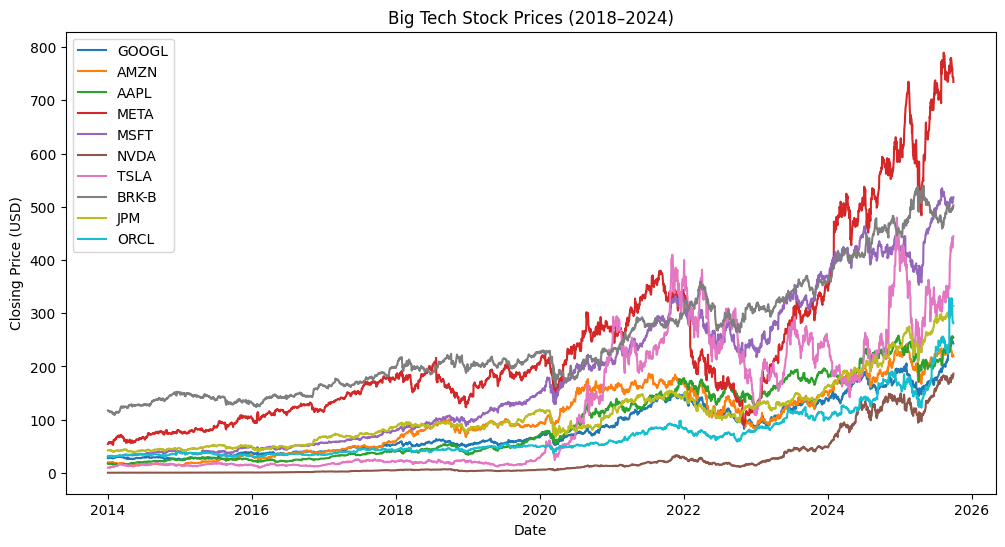

In [90]:
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12,6))

# Generate distinct colors from colormap
colors = cm.tab10(np.linspace(0, 1, len(tickers)))

for i, ticker in enumerate(tickers):
    plt.plot(data[ticker]['Close'], label=ticker, color=colors[i])

plt.title("Big Tech Stock Prices (2018–2024)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()


## 📊**DATA PREPROCESSING**

In [91]:
import pandas as pd
import ta
from sklearn.preprocessing import StandardScaler


def preprocess_stock(df, stock_name):
    """Add technical indicators"""
    df = df.copy()
    df["stock"] = stock_name

    df["RSI"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

    macd = ta.trend.MACD(df["Close"], window_slow=26, window_fast=12, window_sign=9)
    df["MACD"] = macd.macd()
    df["MACD_Signal"] = macd.macd_signal()
    df["MACD_Diff"] = macd.macd_diff()

    bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
    df["BB_High"] = bb.bollinger_hband()
    df["BB_Low"] = bb.bollinger_lband()
    df["BB_Width"] = df["BB_High"] - df["BB_Low"]

    # Create target: NEXT day's close
    df["target"] = df["Close"].shift(-1)

    # Drop rows with NaN
    df.dropna(inplace=True)

    return df

In [92]:
stocks = {
    "META": data["META"],
    "GOOGL": data["GOOGL"],
    "AMZN": data["AMZN"],
    "AAPL": data["AAPL"],
    "MSFT": data["MSFT"],
    "NVDA": data["NVDA"],
    "TSLA": data["TSLA"],
    "BRK-B": data["BRK-B"],
    "JPM": data["JPM"],
    "ORCL": data["ORCL"]
}

processed_stocks = {}
for name, df in stocks.items():
    processed_stocks[name] = preprocess_stock(df, name)


In [93]:
processed_stocks["META"].head()

Price,Open,High,Low,Close,Volume,stock,RSI,MACD,MACD_Signal,MACD_Diff,BB_High,BB_Low,BB_Width,target
Date,,,,,,,,,,,,,,
2014-02-20,67.315024,69.680439,65.327278,69.203377,130928900,META,74.454636,3.031751,2.530497,0.501254,71.433887,52.016080,19.417807,68.169746
2014-02-21,69.263013,69.531355,68.030605,68.169746,70932400,META,69.671598,3.057977,2.635993,0.421984,72.078105,52.560534,19.517571,70.346336
2014-02-24,68.318834,71.002296,68.120063,70.346336,76620300,META,73.528097,3.217308,2.752256,0.465052,72.723980,53.537653,19.186326,69.422028
2014-02-25,70.515286,70.564983,69.024477,69.422028,52077000,META,69.487236,3.231740,2.848153,0.383587,72.754612,55.127033,17.627579,68.835655
2014-02-26,69.759958,70.783646,68.428164,68.835655,55322700,META,66.972691,3.159443,2.910411,0.249032,72.630134,56.654861,15.975272,68.517609


In [94]:
def temporal_split(df, train_ratio=0.7, val_ratio=0.15):
    """Split single stock temporally"""
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train = df.iloc[:train_end].copy()
    val = df.iloc[train_end:val_end].copy()
    test = df.iloc[val_end:].copy()

    return train, val, test

In [95]:
train_dfs = []
val_dfs = []
test_dfs = []

for name, df in processed_stocks.items():
    train, val, test = temporal_split(df)
    train_dfs.append(train)
    val_dfs.append(val)
    test_dfs.append(test)
    print(f"{name}: Train {train.index[0]} to {train.index[-1]}")

META: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
GOOGL: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
AMZN: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
AAPL: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
MSFT: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
NVDA: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
TSLA: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
BRK-B: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
JPM: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00
ORCL: Train 2014-02-20 00:00:00 to 2022-03-30 00:00:00


In [96]:
# Combine splits
train_df = pd.concat(train_dfs, ignore_index=True)
val_df = pd.concat(val_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

In [97]:
# Add stock IDs
stock_to_id = {name: i for i, name in enumerate(stocks.keys())}
train_df["stock_id"] = train_df["stock"].map(stock_to_id)
val_df["stock_id"] = val_df["stock"].map(stock_to_id)
test_df["stock_id"] = test_df["stock"].map(stock_to_id)

In [98]:
# Select features for model input
feature_cols = ["Open", "High", "Low", "Volume",  # NO CLOSE!
                "RSI", "MACD", "MACD_Signal", "MACD_Diff",
                "BB_High", "BB_Low", "BB_Width"]

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit ONLY on training data
feature_scaler.fit(train_df[feature_cols])
target_scaler.fit(train_df[["target"]])


StandardScaler()

In [99]:
# Transform all splits
train_df[feature_cols] = feature_scaler.transform(train_df[feature_cols])
val_df[feature_cols] = feature_scaler.transform(val_df[feature_cols])
test_df[feature_cols] = feature_scaler.transform(test_df[feature_cols])

train_df["target_scaled"] = target_scaler.transform(train_df[["target"]])
val_df["target_scaled"] = target_scaler.transform(val_df[["target"]])
test_df["target_scaled"] = target_scaler.transform(test_df[["target"]])

print(f"\nDataset sizes:")
print(f"Train: {len(train_df)} rows")
print(f"Val:   {len(val_df)} rows")
print(f"Test:  {len(test_df)} rows")


Dataset sizes:
Train: 20430 rows
Val:   4390 rows
Test:  4380 rows


In [100]:
def create_sequences_per_stock(df, feature_cols, seq_len=60):
    """Create sequences within each stock (no mixing across stocks)"""
    all_X = []
    all_y = []
    all_stock_ids = []

    for stock_name in df["stock"].unique():
        stock_data = df[df["stock"] == stock_name].sort_index()

        if len(stock_data) < seq_len + 1:
            continue

        features = stock_data[feature_cols].values
        targets = stock_data["target_scaled"].values
        stock_id = stock_data["stock_id"].iloc[0]

        # Create sequences for this stock
        for i in range(len(stock_data) - seq_len):
            all_X.append(features[i:i+seq_len])
            all_y.append(targets[i+seq_len])
            all_stock_ids.append(stock_id)

    return np.array(all_X), np.array(all_y), np.array(all_stock_ids)

## ➗ Train, Testing And Validation Split

In [101]:
X_train, y_train, stock_ids_train = create_sequences_per_stock(train_df, feature_cols, seq_len=60)
X_val, y_val, stock_ids_val = create_sequences_per_stock(val_df, feature_cols, seq_len=60)
X_test, y_test, stock_ids_test = create_sequences_per_stock(test_df, feature_cols, seq_len=60)

print(f"\nSequence shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")


Sequence shapes:
X_train: (19830, 60, 11), y_train: (19830,)
X_val:   (3790, 60, 11), y_val:   (3790,)
X_test:  (3780, 60, 11), y_test:  (3780,)


## DATALOADER AND DATASET

In [102]:
import torch
from torch.utils.data import DataLoader, Dataset


class MultiStockDataset(Dataset):
    def __init__(self, X, y, stock_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        self.stock_ids = torch.tensor(stock_ids, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.stock_ids[idx], self.y[idx]

train_dataset = MultiStockDataset(X_train, y_train, stock_ids_train)
val_dataset = MultiStockDataset(X_val, y_val, stock_ids_val)
test_dataset = MultiStockDataset(X_test, y_test, stock_ids_test)

# CRITICAL: shuffle=False for time series validation!
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Can shuffle within training
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)     # NO shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("=" * 60)

In [103]:
def compute_baseline(val_loader):
    """Baseline: predict that tomorrow's price = today's last known price"""
    all_targets = []
    all_last_prices = []

    for X_batch, _, y_batch in val_loader:
        # Last value in sequence (but we removed Close from features!)
        # So we need to use the target from previous timestep as proxy
        # For true baseline, you'd want to keep track of actual prices
        all_targets.extend(y_batch.numpy())

    # Simple baseline: predict mean of training targets
    train_mean = y_train.mean()
    baseline_preds = np.full(len(all_targets), train_mean)
    baseline_mse = np.mean((np.array(all_targets) - baseline_preds) ** 2)

    print(f"\nBaseline MSE (predict training mean): {baseline_mse:.6f}")
    return baseline_mse

baseline_mse = compute_baseline(val_loader)


Baseline MSE (predict training mean): 2.526379


### 🏗️ Model Architecture
- MultiStockLSTM (shared LSTM layers + stock embedding)
- Optimizer: Adam
- Loss: MSE
- Number of Layers: 2
- Hidden State: 32
- Epochs: 10

In [105]:
import torch.nn as nn

class MultiStockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.4, num_stocks=10, embed_dim=2):
        super(MultiStockLSTM, self).__init__()

        self.stock_embed = nn.Embedding(num_stocks, embed_dim)
        self.lstm = nn.LSTM(input_size + embed_dim, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, stock_id):
        stock_emb = self.stock_embed(stock_id)
        stock_emb = stock_emb.unsqueeze(1).repeat(1, x.size(1), 1)
        x = torch.cat((x, stock_emb), dim=2)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


### 📊 Training Performance

Epoch 10, Train Loss: `0.0272`

In [106]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiStockLSTM(input_size=len(feature_cols), num_stocks=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = {
    'train_loss': [],
    'val_loss': [],
    'epochs': []
}

best_val_loss = float('inf')
patience_counter = 0
max_patience = 15

print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60)


for epoch in range(10):
    # Training
    model.train()
    train_loss = 0
    for X_batch, stock_batch, y_batch in train_loader:
        # In training loop
        X_batch, stock_batch, y_batch = X_batch.to(device), stock_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch, stock_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, stock_batch, y_batch in val_loader:
            X_batch, stock_batch, y_batch = X_batch.to(device), stock_batch.to(device), y_batch.to(device)
            preds = model(X_batch, stock_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)

    history['train_loss'].append(avg_train)
    history['val_loss'].append(avg_val)
    history['epochs'].append(epoch + 1)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, ")



TRAINING STARTED
Epoch 1, Train Loss: 0.1241, 
Epoch 2, Train Loss: 0.0330, 
Epoch 3, Train Loss: 0.0303, 
Epoch 4, Train Loss: 0.0291, 
Epoch 5, Train Loss: 0.0273, 
Epoch 6, Train Loss: 0.0291, 
Epoch 7, Train Loss: 0.0279, 
Epoch 8, Train Loss: 0.0276, 
Epoch 9, Train Loss: 0.0275, 
Epoch 10, Train Loss: 0.0272, 


### 🔍 Validation Results
Actual vs predicted close price for each stock:
- Single plot per stock
- RMSE and R² in chart titles

Validation Set:


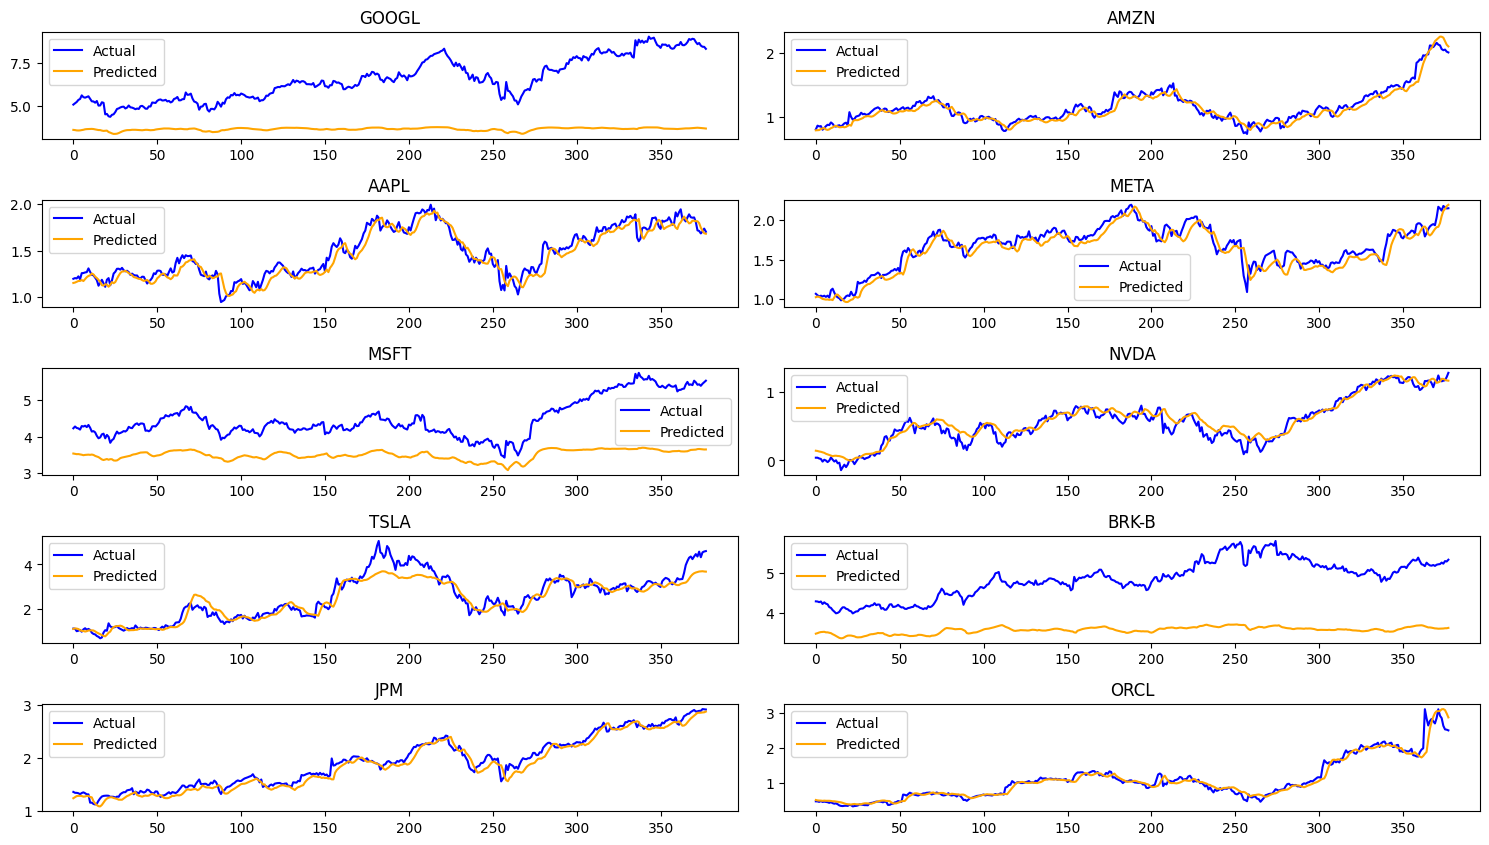

Test Set:


In [107]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

model.eval()
preds, actuals, stock_labels = [], [], []

with torch.no_grad():
    for X_batch, stock_batch, y_batch in test_loader:
        X_batch, stock_batch, y_batch = X_batch.to(device), stock_batch.to(device), y_batch.to(device)
        outputs = model(X_batch, stock_batch)
        preds.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())
        stock_labels.append(stock_batch.cpu().numpy())

preds = np.concatenate(preds).reshape(-1)
actuals = np.concatenate(actuals).reshape(-1)
stock_labels = np.concatenate(stock_labels).reshape(-1)


def plot_predictions_per_stock(actuals, preds, stocks, stock_names):
    unique_stocks = np.unique(stocks)
    plt.figure(figsize=(15, 10))

    for i, stock_id in enumerate(unique_stocks):
        mask = stocks == stock_id
        plt.subplot(len(unique_stocks)//2 + 1, 2, i+1)
        plt.plot(actuals[mask], label="Actual", color="blue")
        plt.plot(preds[mask], label="Predicted", color="orange")
        plt.title(stock_names[stock_id])
        plt.legend()

    plt.tight_layout()
    plt.show()




print("Validation Set:")
plot_predictions_per_stock(actuals, preds, stock_labels, tickers)

print("Test Set:")
# plot_predictions_per_stock(test_actuals, test_preds, test_stocks, tickers)


### 🧾 Evaluation Summary
- Overall RMSE: `1.1296`
- Overall R² Score: `0.6761`

In [108]:

rmse = np.sqrt(mean_squared_error(actuals, preds))
r2 = r2_score(actuals, preds)

print(f"\nOverall RMSE: {rmse:.6f}")
print(f"Overall R² Score: {r2:.6f}")



Overall RMSE: 1.135478
Overall R² Score: 0.672785


## Multi-stock Performance Summary Dashboard

In [109]:
def evaluate_model(model, data_loader, scaler, device, dataset_name="Validation"):
    """Comprehensive evaluation with metrics"""
    model.eval()

    all_preds = []
    all_targets = []
    all_stock_ids = []

    with torch.no_grad():
        for X_batch, stock_batch, y_batch in data_loader:
            X_batch, stock_batch = X_batch.to(device), stock_batch.to(device)
            preds = model(X_batch, stock_batch)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.numpy())
            all_stock_ids.extend(stock_batch.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets).flatten()
    all_stock_ids = np.array(all_stock_ids)

    # Denormalize predictions back to actual prices
    all_preds_actual = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()
    all_targets_actual = target_scaler.inverse_transform(all_targets.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_preds - all_targets))

    # Actual price metrics
    mse_actual = np.mean((all_preds_actual - all_targets_actual) ** 2)
    rmse_actual = np.sqrt(mse_actual)
    mae_actual = np.mean(np.abs(all_preds_actual - all_targets_actual))

    # Directional accuracy
    pred_direction = np.sign(all_preds)
    target_direction = np.sign(all_targets)
    directional_accuracy = np.mean(pred_direction == target_direction)

    # R² score
    ss_res = np.sum((all_targets - all_preds) ** 2)
    ss_tot = np.sum((all_targets - np.mean(all_targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    print(f"\n{'='*60}")
    print(f"{dataset_name.upper()} RESULTS")
    print(f"{'='*60}")
    print(f"Scaled Metrics:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"\nActual Price Metrics:")
    print(f"  MSE:  ${mse_actual:.2f}")
    print(f"  RMSE: ${rmse_actual:.2f}")
    print(f"  MAE:  ${mae_actual:.2f}")
    print(f"\nOther Metrics:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  Directional Accuracy: {directional_accuracy:.2%}")
    print(f"{'='*60}\n")

    return {
        'predictions': all_preds,
        'targets': all_targets,
        'predictions_actual': all_preds_actual,
        'targets_actual': all_targets_actual,
        'stock_ids': all_stock_ids,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mse_actual': mse_actual,
        'rmse_actual': rmse_actual,
        'mae_actual': mae_actual,
        'directional_accuracy': directional_accuracy,
        'r2': r2
    }

# Evaluate on validation and test sets
val_results = evaluate_model(model, val_loader, target_scaler, device, "Validation")
test_results = evaluate_model(model, test_loader, target_scaler, device, "Test")


VALIDATION RESULTS
Scaled Metrics:
  MSE:  0.013344
  RMSE: 0.115518
  MAE:  0.078682

Actual Price Metrics:
  MSE:  $80.75
  RMSE: $8.99
  MAE:  $6.12

Other Metrics:
  R² Score: 0.9908
  Directional Accuracy: 98.58%


TEST RESULTS
Scaled Metrics:
  MSE:  1.289310
  RMSE: 1.135478
  MAE:  0.587232

Actual Price Metrics:
  MSE:  $7802.21
  RMSE: $88.33
  MAE:  $45.68

Other Metrics:
  R² Score: 0.6728
  Directional Accuracy: 99.55%



✅ Plot saved as 'stock_prediction_results.png'


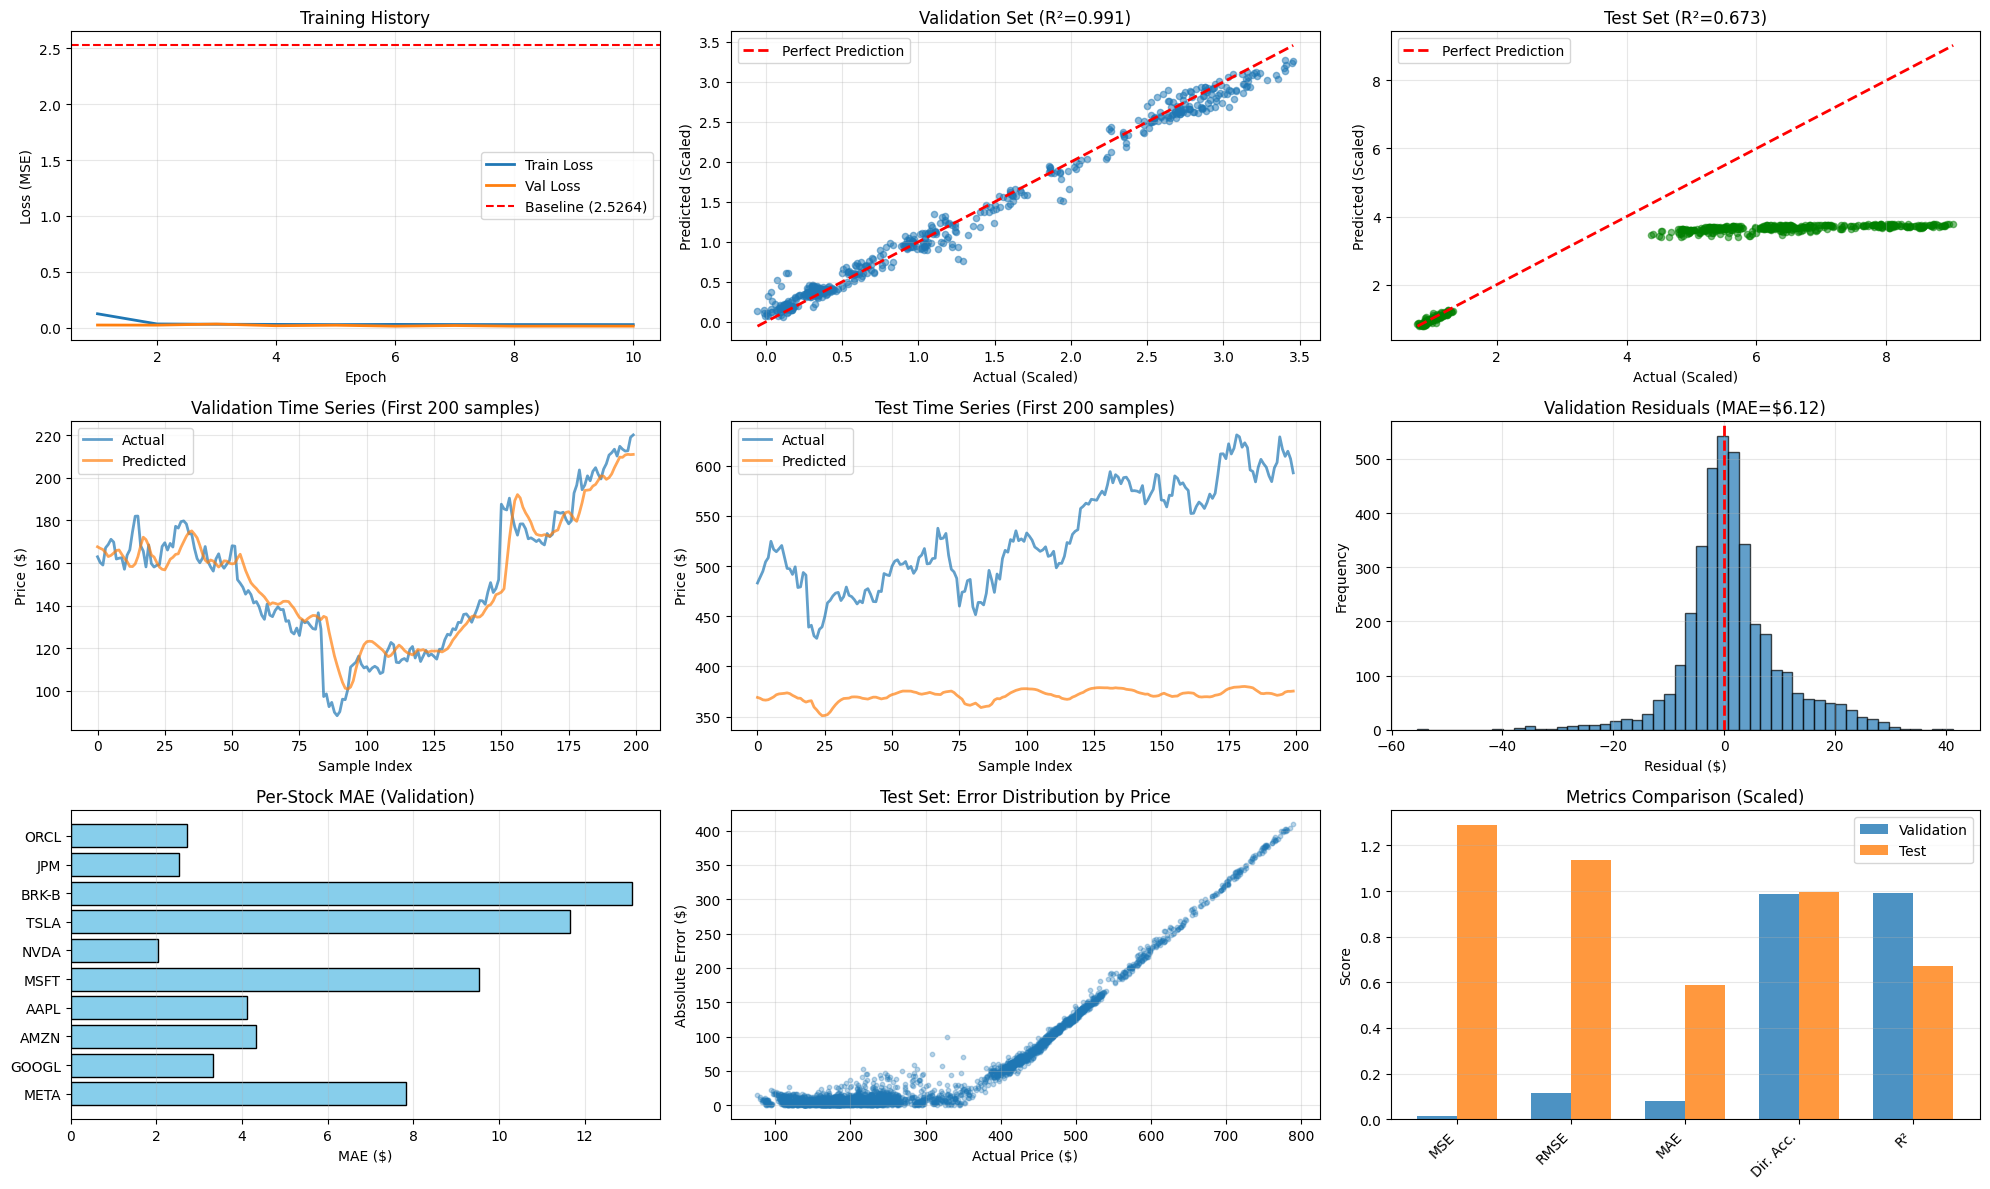

In [110]:
def plot_results(history, val_results, test_results, stock_to_id):
    """Create comprehensive visualization"""
    fig = plt.figure(figsize=(20, 12))

    # 1. Training History
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(history['epochs'], history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['epochs'], history['val_loss'], label='Val Loss', linewidth=2)
    ax1.axhline(y=baseline_mse, color='r', linestyle='--', label=f'Baseline ({baseline_mse:.4f})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_title('Training History')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Validation Predictions vs Actual (Scaled)
    ax2 = plt.subplot(3, 3, 2)
    sample_size = min(500, len(val_results['predictions']))
    ax2.scatter(val_results['targets'][:sample_size],
                val_results['predictions'][:sample_size],
                alpha=0.5, s=20)
    min_val = min(val_results['targets'][:sample_size].min(), val_results['predictions'][:sample_size].min())
    max_val = max(val_results['targets'][:sample_size].max(), val_results['predictions'][:sample_size].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax2.set_xlabel('Actual (Scaled)')
    ax2.set_ylabel('Predicted (Scaled)')
    ax2.set_title(f'Validation Set (R²={val_results["r2"]:.3f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Test Predictions vs Actual (Scaled)
    ax3 = plt.subplot(3, 3, 3)
    sample_size = min(500, len(test_results['predictions']))
    ax3.scatter(test_results['targets'][:sample_size],
                test_results['predictions'][:sample_size],
                alpha=0.5, s=20, color='green')
    min_val = min(test_results['targets'][:sample_size].min(), test_results['predictions'][:sample_size].min())
    max_val = max(test_results['targets'][:sample_size].max(), test_results['predictions'][:sample_size].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax3.set_xlabel('Actual (Scaled)')
    ax3.set_ylabel('Predicted (Scaled)')
    ax3.set_title(f'Test Set (R²={test_results["r2"]:.3f})')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Validation Time Series (Actual Prices)
    ax4 = plt.subplot(3, 3, 4)
    plot_range = slice(0, min(200, len(val_results['predictions_actual'])))
    ax4.plot(val_results['targets_actual'][plot_range], label='Actual', linewidth=2, alpha=0.7)
    ax4.plot(val_results['predictions_actual'][plot_range], label='Predicted', linewidth=2, alpha=0.7)
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Price ($)')
    ax4.set_title('Validation Time Series (First 200 samples)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Test Time Series (Actual Prices)
    ax5 = plt.subplot(3, 3, 5)
    plot_range = slice(0, min(200, len(test_results['predictions_actual'])))
    ax5.plot(test_results['targets_actual'][plot_range], label='Actual', linewidth=2, alpha=0.7)
    ax5.plot(test_results['predictions_actual'][plot_range], label='Predicted', linewidth=2, alpha=0.7)
    ax5.set_xlabel('Sample Index')
    ax5.set_ylabel('Price ($)')
    ax5.set_title('Test Time Series (First 200 samples)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Residuals Distribution (Validation)
    ax6 = plt.subplot(3, 3, 6)
    residuals = val_results['targets_actual'] - val_results['predictions_actual']
    ax6.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax6.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax6.set_xlabel('Residual ($)')
    ax6.set_ylabel('Frequency')
    ax6.set_title(f'Validation Residuals (MAE=${val_results["mae_actual"]:.2f})')
    ax6.grid(True, alpha=0.3)

    # 7. Per-Stock Performance (Validation)
    ax7 = plt.subplot(3, 3, 7)
    id_to_stock = {v: k for k, v in stock_to_id.items()}
    stock_maes = []
    stock_names = []
    for stock_id in range(len(stock_to_id)):
        mask = val_results['stock_ids'] == stock_id
        if mask.sum() > 0:
            stock_mae = np.mean(np.abs(val_results['predictions_actual'][mask] -
                                       val_results['targets_actual'][mask]))
            stock_maes.append(stock_mae)
            stock_names.append(id_to_stock[stock_id])

    ax7.barh(stock_names, stock_maes, color='skyblue', edgecolor='black')
    ax7.set_xlabel('MAE ($)')
    ax7.set_title('Per-Stock MAE (Validation)')
    ax7.grid(True, alpha=0.3, axis='x')

    # 8. Error by Prediction Magnitude
    ax8 = plt.subplot(3, 3, 8)
    abs_errors = np.abs(test_results['targets_actual'] - test_results['predictions_actual'])
    ax8.scatter(test_results['targets_actual'], abs_errors, alpha=0.3, s=10)
    ax8.set_xlabel('Actual Price ($)')
    ax8.set_ylabel('Absolute Error ($)')
    ax8.set_title('Test Set: Error Distribution by Price')
    ax8.grid(True, alpha=0.3)

    # 9. Metrics Comparison
    ax9 = plt.subplot(3, 3, 9)
    metrics = ['MSE', 'RMSE', 'MAE', 'Dir. Acc.', 'R²']
    val_values = [val_results['mse'], val_results['rmse'], val_results['mae'],
                  val_results['directional_accuracy'], max(0, val_results['r2'])]
    test_values = [test_results['mse'], test_results['rmse'], test_results['mae'],
                   test_results['directional_accuracy'], max(0, test_results['r2'])]

    x = np.arange(len(metrics))
    width = 0.35
    ax9.bar(x - width/2, val_values, width, label='Validation', alpha=0.8)
    ax9.bar(x + width/2, test_values, width, label='Test', alpha=0.8)
    ax9.set_ylabel('Score')
    ax9.set_title('Metrics Comparison (Scaled)')
    ax9.set_xticks(x)
    ax9.set_xticklabels(metrics, rotation=45, ha='right')
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('stock_prediction_results.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved as 'stock_prediction_results.png'")
    plt.show()

# Generate plots
plot_results(history, val_results, test_results, stock_to_id)


In [111]:
def analyze_per_stock(results, dataset_name, stock_to_id):
    """Detailed analysis for each stock"""
    print(f"\n{'='*60}")
    print(f"PER-STOCK ANALYSIS - {dataset_name.upper()}")
    print(f"{'='*60}")

    id_to_stock = {v: k for k, v in stock_to_id.items()}

    stock_metrics = []
    for stock_id in sorted(stock_to_id.values()):
        mask = results['stock_ids'] == stock_id
        if mask.sum() == 0:
            continue

        stock_name = id_to_stock[stock_id]
        preds = results['predictions_actual'][mask]
        targets = results['targets_actual'][mask]

        mae = np.mean(np.abs(preds - targets))
        rmse = np.sqrt(np.mean((preds - targets) ** 2))
        mape = np.mean(np.abs((preds - targets) / (targets + 1e-8))) * 100

        pred_dir = np.sign(preds[1:] - preds[:-1])
        target_dir = np.sign(targets[1:] - targets[:-1])
        dir_acc = np.mean(pred_dir == target_dir)

        stock_metrics.append({
            'Stock': stock_name,
            'Samples': mask.sum(),
            'MAE ($)': mae,
            'RMSE ($)': rmse,
            'MAPE (%)': mape,
            'Dir. Acc.': dir_acc
        })

    df_metrics = pd.DataFrame(stock_metrics)
    print(df_metrics.to_string(index=False))
    print(f"{'='*60}\n")

    return df_metrics

val_stock_metrics = analyze_per_stock(val_results, "Validation", stock_to_id)
test_stock_metrics = analyze_per_stock(test_results, "Test", stock_to_id)

print("\n Analysis complete! Check 'stock_prediction_results.png' for visualizations.")


PER-STOCK ANALYSIS - VALIDATION
Stock  Samples   MAE ($)  RMSE ($)  MAPE (%)  Dir. Acc.
 META      379  7.829834 10.403214  4.075017   0.502646
GOOGL      379  3.315151  4.262839  3.138933   0.447090
 AMZN      379  4.324781  5.753215  3.939680   0.476190
 AAPL      379  4.127416  4.910052  2.545604   0.462963
 MSFT      379  9.540591 11.989956  3.231936   0.462963
 NVDA      379  2.039853  2.566246  7.764648   0.502646
 TSLA      379 11.665449 14.872213  5.588646   0.537037
BRK-B      379 13.108559 15.120713  3.977457   0.481481
  JPM      379  2.535454  3.205969  2.065681   0.489418
 ORCL      379  2.720400  3.671822  3.027637   0.486772


PER-STOCK ANALYSIS - TEST
Stock  Samples    MAE ($)   RMSE ($)  MAPE (%)  Dir. Acc.
 META      378 224.574692 242.436325 36.141457   0.527851
GOOGL      378   4.946466   6.157579  2.756671   0.432361
 AMZN      378   5.051862   6.560977  2.517412   0.522546
 AAPL      378   6.211015   7.796108  2.883127   0.498674
 MSFT      378  76.524841  83.276